In [129]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

import Backgammon as B
import agent as A
import flipped_agent as FA

In [136]:
class backgammon:
    def __init__(self):
        self.board = B.init_board()
            
    def reset(self):
        self.board = B.init_board()
        self.done = False
    
    def legal_moves(self, dice, player):
        moves, boards = B.legal_moves(board = self.board, dice = dice, player = player)
        if len(boards) == 0:
            return [], []
        return moves, np.vstack(boards)
    
    def swap_player(self):
        self.board = FA.flip_board(board_copy=np.copy(self.board))
    
    # oppents random move
    def make_move(self, dice):
        moves, _ = self.legal_moves(dice, -1)
        if len(moves) == 0:
            return self.step([], -1)
        move = moves[np.random.randint(len(moves))]
        return self.step(move, -1)
    
    def step(self, move, player):
        if len(move) != 0:
            for m in move:
                self.board = B.update_board(board = self.board, move = m, player = player)
        reward = 0
        self.done = False
        if self.iswin():
            reward = player
            self.done = True
        return np.copy(self.board), reward, self.done
        
    def iswin(self):
        return B.game_over(self.board)
        
    def render(self):
        B.pretty_print(self.board)

In [137]:
def reset_graph(seed=42):
    #tf.reset_default_graph()
    #tf.set_random_seed(seed)
    torch.manual_seed(seed)
    np.random.seed(seed)
reset_graph()

In [138]:
# D_in is input dimension;
# H is hidden dimension; D_out is output dimension.
D_in, H1, H2, D_out = 29, 32, 32, 1

actor = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, D_out),
    torch.nn.Softmax(dim=0),
)
critic = torch.nn.Sequential(
    torch.nn.Linear(D_in, H1),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H1, H2),
    torch.nn.LeakyReLU(),
    torch.nn.Linear(H2, D_out),
    torch.nn.Tanh(),
)

In [139]:
def get_action_value(actor, boards, action):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action_value = possible_actions_probs[action]
    return action_value

def get_action(actor, boards):
    boards = torch.from_numpy(boards).float()
    possible_actions_probs = actor(boards)
    action = torch.multinomial(possible_actions_probs.view(1,-1), 1)
    return int(action)

def get_state_value(critic, after_state):
    after_state = torch.from_numpy(after_state).float()
    value = critic(after_state)
    return value

def epsilon_greedy(critic, possible_boards, epsilon=.9):
    possible_boards = torch.from_numpy(possible_boards).float()
    values = critic(possible_boards)
    if np.random.random()<epsilon:
        _ , index = values.max(0)
    else:
        index = np.random.randint(0, len(possible_boards))
    return int(index)

Reward:  1


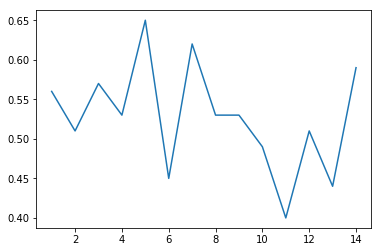

Episode: 1400
time per 100 : 6.602154016494751
board: 
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[-1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
[  0.   0.  15. -14.]


KeyboardInterrupt: 

In [140]:
gamma = 0.98
actor_alpha = 0.2
critic_alpha = 0.2
forever = 100000

plt_iter = 100
rew = []
rew_plt = []

from time import time
tic = time()

for episode in range(forever):      
    env = backgammon()
    done = False
    I = 1
    i = 0
    Error = False

    while not done:
        with torch.no_grad():
            dice = B.roll_dice()
            for i in range(1 + int(dice[0] == dice[1])):
                possible_moves, possible_boards = env.legal_moves(dice, 1)
                
                if len(possible_moves) == 0:
                    break
                
                action = get_action(actor, possible_boards) # Using actor
                after_state, reward, done = env.step(possible_moves[action], player = 1)
                if done:
                    break
            if not done:
                value = get_state_value(critic, after_state)
            else:
                value = 0
            # other players move
            if not done:
                dice = B.roll_dice()
                for i in range(1 + int(dice[0] == dice[1])):
                    next_state, reward, done = env.make_move(dice)
                    if done:
                        break
                next_value = get_state_value(critic, next_state)
            else:
                next_value = 0
            #delta = reward + gamma*next_value - value
            if (i>1):
                delta = reward + gamma*value - old_value
            old_value = value
        
        ###### plot
        if episode%plt_iter == 0:
            if done:
                clear_output(True)
                print('Reward: ',reward)
                rew_plt.append(np.mean(np.equal(rew,1)))
                rew = []
                plt.plot(rew_plt)
                plt.show()
                rnd = False
                print("Episode: {}".format(episode))
                toc=time()
                print('time per',plt_iter,':',toc-tic)
                tic=toc
                env.render()
        ######
         
        if (i>1):
            # apply gradients
            value = get_state_value(critic, after_state)
            critic.zero_grad()
            value.backward()
            with torch.no_grad():
                for param in critic.parameters():
                    param += critic_alpha * delta * param.grad
        
            pi = get_action_value(actor, possible_boards, action)
            pi.clamp(min=1e-8) # so that log does not become nan
            log_pi = torch.log(pi) 
            actor.zero_grad()
            log_pi.backward()
            with torch.no_grad():
                for param in actor.parameters():
                    param += actor_alpha * I * delta * param.grad
            
        I *= gamma
        i = i+1
        
    rew.append(reward)
    actor_alpha *= 0.99
    critic_alpha *= 0.99

In [83]:
possible_moves, possible_boards = backgammon().legal_moves(1)
get_action_value(actor, possible_boards)

TypeError: get_action_value() missing 1 required positional argument: 'action'

In [111]:
backgammon().render()

board: 
 [-2.  0.  0.  0.  0.  5.  0.  3.  0.  0.  0. -5.]
[ 2.  0.  0.  0.  0. -5.  0. -3.  0.  0.  0.  5.]
[0. 0. 0. 0.]
